In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/damien/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn import datasets

iris_dataset = datasets.load_iris()

Let's start by looking at two different classifiers for the iris dataset, just to get used to what we wamt.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, label_train, label_test = train_test_split(iris_dataset['data'], iris_dataset['target'], test_size=0.3, random_state=41)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, label_train)
print("The score for KNN is")
print("Training: {:6.4f}%".format(100*knn.score(X_train, label_train)))
print("Test set: {:6.4f}%".format(100*knn.score(X_test, label_test)))

The score for KNN is
Training: 100.0000%
Test set: 93.3333%


In [5]:
lm = LogisticRegression(C = 0.95)
lm.fit(X_train, label_train)
print("The score for Logistic regression is")
print("Training: {:6.4f}%".format(100*lm.score(X_train, label_train)))
print("Test set: {:6.4f}%".format(100*lm.score(X_test, label_test)))

The score for Logistic regression is
Training: 97.1429%
Test set: 88.8889%


Unlike kNN, the logistic regression model has a probabiltiy method built into it.

We probably want to penalize a prediction that we claim we are really sure about more than one that was just barely over 33%.

In [6]:
# Let's do  a prediction of the first 5 datasets
lm.predict_proba(X_test[:5,])

array([[  1.47949079e-03,   4.62473365e-01,   5.36047144e-01],
       [  7.01069755e-04,   2.96640121e-01,   7.02658809e-01],
       [  4.43650165e-04,   3.73953539e-01,   6.25602811e-01],
       [  2.52873279e-02,   5.33232236e-01,   4.41480436e-01],
       [  1.49634307e-03,   3.16047331e-01,   6.82456326e-01]])

Let's look at the type of errors that these two classifiers made:

In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(label_test, knn.predict(X_test))

array([[11,  0,  0],
       [ 0, 16,  2],
       [ 0,  1, 15]])

i.e. the kNN confused two samples of species 1 as species 2, and one species 2 as a species 1, but managed to get all of the species 0 irises right. 

Note that `confusion[row_number][col_number]` tells us how many of the labels that were actually `row_number` were predicted to be `col_number` by our classifier. We can see that by making predictions that are "all class 2"

In [8]:
# What happens when our "prediction" is all class 2?
confusion_matrix(label_test, [2]*len(label_test))

array([[ 0,  0, 11],
       [ 0,  0, 18],
       [ 0,  0, 16]])

We can make this a little prettier by passing confusion matrix to `sns.heatmap`:

/Users/damien/miniconda2/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/damien/miniconda2/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


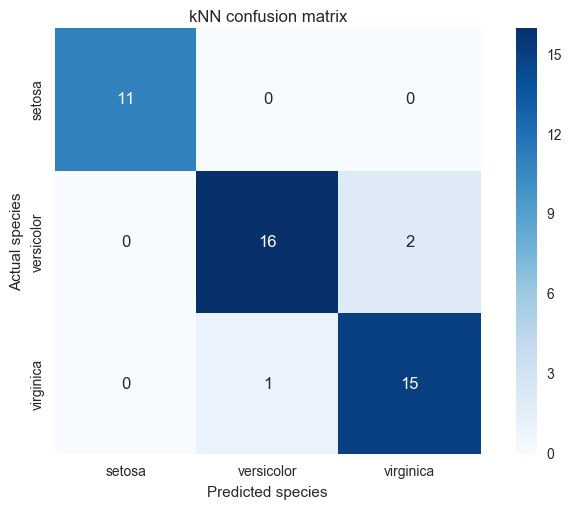

In [9]:
import seaborn as sns

knn_confusion = confusion_matrix(label_test, knn.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=iris_dataset['target_names'],
           yticklabels=iris_dataset['target_names'])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('kNN confusion matrix');

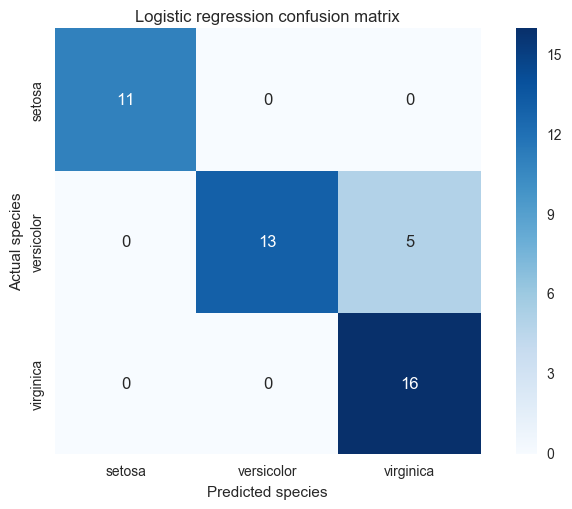

In [10]:
# For logistic regression:
lm_confusion = confusion_matrix(label_test, lm.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(lm_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=iris_dataset['target_names'],
           yticklabels=iris_dataset['target_names'])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Logistic regression confusion matrix');

## Binary classification

Binary classification has two outcomes, which are usually labelled as the "positive" class (the one that we are trying to detect) and a "negative class" (the normal case). For example

| Test | + class | - class |
| --- | --- | --- |
| Drug test | Has taken the drug | Hasn't taken the drug |
| Breath test | BAC is over legal limit | BAC is not over legal limit |
| Pregnancy test | Is pregnant | Isn't pregnant | 
| Background check | Is a threat | Is not a threat |
| Water Diviner | Found water | Did not find water |
| Amy's movie recommender | Found a good movie (7+ stars) | Found a not good movie (< 7 stars)|
| Gold panner | Found gold | Did not find gold | 
| Explosive detector | Is a bomb | Isn't a bomb |
| A not-bomb detector | Isn't a bomb | Is a bomb |

We are going to look at an example of credit card data, where the positive class is "transaction is fraudulant" and the negative class is "transaction is not fraudulant".

### Reminder of key terms:

| | Test positive | Test negative |
|--- | --- | --- |
| **Actually positive ** | True positive | False negative (Type II error) |
| **Actually negative ** | False positive (Type I error) | True negative |

i.e. a false positive is a transaction we flag as fraudulant that is actually legitimite, whereas a false negative is a transaction we claim is legitimate that turns out to be fraudulant.

In [11]:
# Let's read in some credit card data!
# Dataset available at https://www.kaggle.com/mlg-ulb/creditcardfraud/data or
# from 
# https://github.com/kiwidamien/my_metis_materials/raw/master/accuracy_metrics/data/creditcard.csv.gz
df = pd.read_csv('./data/creditcard.csv.gz')

Let's look at the distribution of fraud to non-fraud cases

In [12]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Wow! If we just guess class 0 (non-fraud transactions) we will get the right answer 284315/(284315 + 492) = 99.8% of the time! If accuracy is the metric, we have a very simple model that does very well:

**Model 0:** guess all transactions are legitimate (accuracy 99.8%)

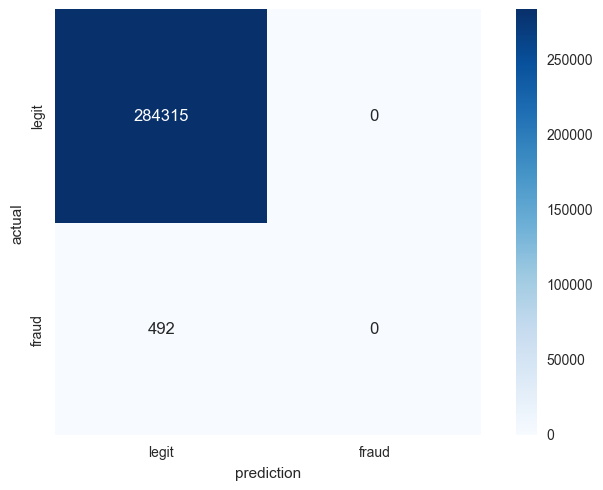

In [24]:
predictions = [0]*len(df)
fraud_confusion = confusion_matrix(df.Class, predictions)
plt.figure(dpi=100)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [25]:
# Let's make a slightly better model
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-1], df.iloc[:, -1])
lm = LogisticRegression(C = 1.3)
lm.fit(X_train, y_train)
lm.score(X_train,y_train)

0.99919477540319745

In [26]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

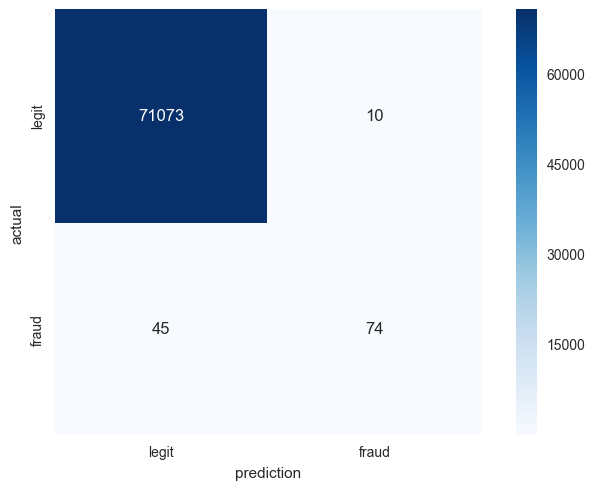

In [27]:
make_confusion_matrix(lm)

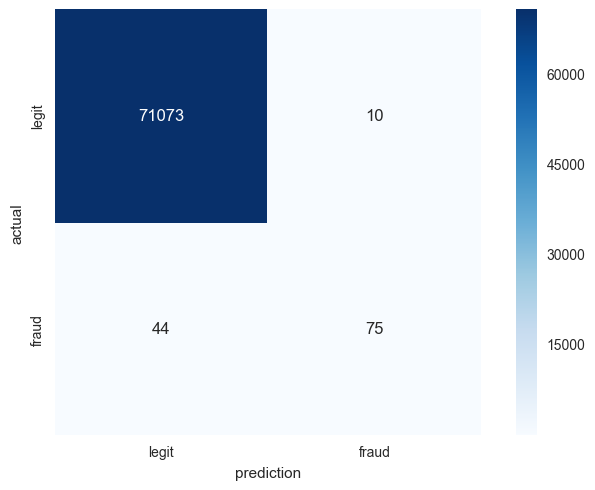

In [106]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

By reducing the threshold to 6% (i.e. our model only gives a 6% chance the transaction is fradulent), we have halved the number of people that got away with fraudulent charges [from 47 to 23]. We had to pay for this by increasing the number of good customers that we inconvienced [from 11 to 30].

We can introduce two new metrics:
- **Precision:** The fraction of postive predictions you made that were correct. 
  High precision means that if your model predicted a positive case, you believe it with high confidence. It doesn't tell us how many postive cases we missed (i.e. it doesn't tell us how sure we are about the cases we predicted were negative).
- **Recall**: The fraction of positive cases you predicted correctly.
  High recall means that you are confident that you didn't miss any positive cases. 
  
The easiest way to get high precision is to call a point "positive" only when you are very sure. The easiest way to get 100% recall is to predict all points to be positive, as you are guaranteed to label 100% of all positive cases. You should not optimize for either recall or precision -- you need to think about how to balance them against one another.

In formula:
$$ \text{Precision} = \frac{\text{(True positives)}}{\text{Predicted positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False postitives}}$$
and
$$ \text{Recall} = \frac{\text{True positives}}{\text{Actual positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False negatives}}$$

### Example calcuation: fraud when threshold = 0.5 

| | predicted negative (legit) | predicted positive (fraud) | Total |
|---| --- | --- | --- |
| **actual negative (legit)** | 71058 | 11 | 71069 |
| **actual positive (fraud)** | 47 | 86 | 133 |
| **Total** | 71105 | 97 | 71202|


For precision:
$$\text{Precision} = \frac{TP}{\text{predicted positive}} = \frac{86}{86 + 11} = 0.887$$
i.e. this 88.7% of the tests positive predictions are correct.

For recall:
$$\text{Recall} = \frac{TP}{\text{actual positives}} = \frac{86}{86+47} = 0.647$$
i.e. the model can only get (or 'remember'/'recall') 64.7% of fraudulent transactions.


### Example calculation: fraud when threshold = 0.06

| | predicted negative (legit) | predicted positive (fraud) | Total |
|---| --- | --- | --- |
| **actual negative (legit)** | 71039 | 30 | 71069 |
| **actual positive (fraud)** | 23 | 110 | 133 |
| **Total** | 71062 | 140 | 71202|

Calculating precision and recall:
* Precision = 110 / 140 = 78.5%
* Recall = 110 / 133 = 82.7%
i.e. by lowering the probability threshold before we label a transaction fraud, we caught more fraud (high recall), but we also investigated more innocent transactions (lower precision).

## Big takeaways:

* Using the **same** logistic regression model, we can change the threshold to bias toward more precision (making positives from test more relevant) or recall (increasing the fraction of postives found).
* Precision goes down as you decrease the threshold, while recall goes up. This is called the _precision-recall tradeoff_.
* Which is worse, low recall or low precision? Depends on the cost of making the different types of error.
* We just need the final predictions of the model to calculate precision and recall. We can get sklearn.metrics to calculate them for us

In [107]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# using the default threshold of 0.5, which is what "vanilla" predict does
y_predict = lm.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.8810,   Recall: 0.6218


In [108]:
# using the default threshold of 0.06
y_predict = (lm.predict_proba(X_test)[:,1] > 0.06)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.06:
Precision: 0.7120,   Recall: 0.7479


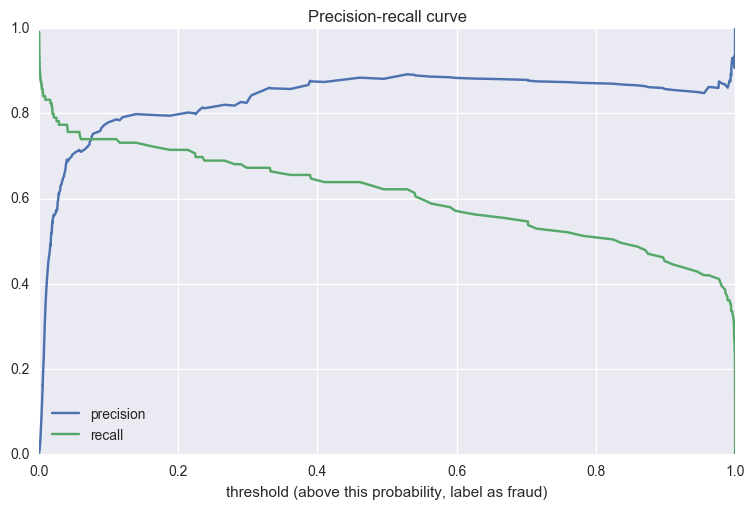

In [109]:
# We can also use the probabilities / scores to make a curve showing us how recall and thresholds trade off 
# against one another
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1] )

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('threshold (above this probability, label as fraud)');
plt.title('Precision-recall curve')

There is a balance between precision and recall. A quick-and-dirty method for estimating a good balance is tolook at the $F_1$ score, defined as 

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

The goal here is to find a balance between a good recall score and a good precision score. We can calculate it manually.

For the default threshold we have

precision = 0.8810, recall = 0.6218

so

$$F_1 = 2\frac{(0.8810)(0.6218)}{0.8810 + 0.6218} = 0.7290$$

In [110]:
# Or we can just ask sklearn
y_predict = lm.predict(X_test)
f1_score(y_test, y_predict)

0.72906403940886699

In [111]:
# What about the threshold of 0.06?
y_predict = (lm.predict_proba(X_test)[:, 1] > 0.06)
f1_score(y_test, y_predict)

0.72950819672131151

As the name suggests, there is actually a whole family of $F_1$ scores. We have in general:

$$F_{\beta} = \frac{\text{precision} \times \text{recall}}{\text{weighted average of precision and recall}}$$

where the weighted average is given by

$$\text{weighted average} = \frac{\beta^2 \times \text{precision} + 1 \times \text{recall}}{\beta^2 + 1}$$

The rough interpretation is that $F_{\beta}$ attaches $\beta$ times more importance to recall than precision. (This might seem the wrong way around, but put in $\beta = 0$ and see what happens!)

## The ROC curve

Whenever we have scores, where a higher score means "more likely to be positive", we have to choose a threshold. If we have probabilities, we can use them as a score. There is a common type of curve used to evaluate classification algorithms called the _Reciever Operating Characteristic_ or _ROC_ curve.

It plots the *True positive rate* on the y axis, and the *False positive rate* on the x axis. We these against one another, ignoring thresholds.

In [112]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

ROC AUC score =  0.958618265758


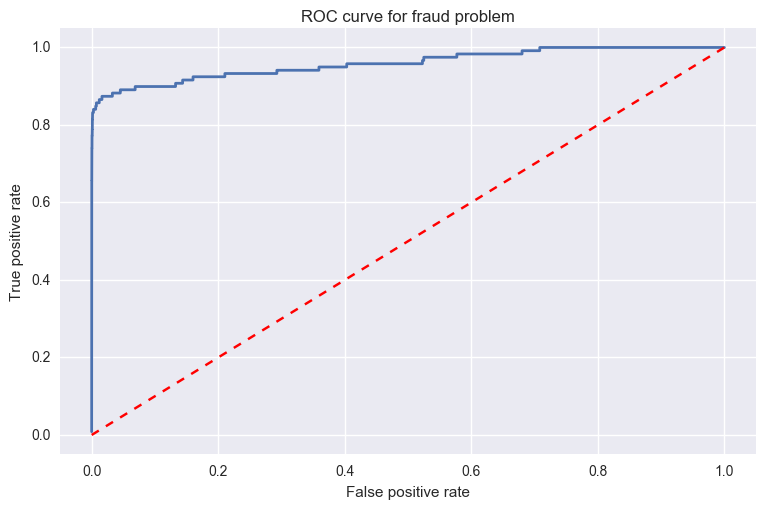

In [113]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1]))

The intepretation of the _Area Under the Curve_ (AUC) is the probability that a randomly chosen positive example (in this case, fraud) has a higher score than the randomly chosen negative example (in this case, legitimate transactions).

We see here all the possible TPRs and FNRs that we could have. It is a nice metric because looking at the behavior of our model, we can choose later what we want the threshold to be.


**Question 1: Where would a "perfect classifier" look like on this diagram? **

**Question 2: What is the significance of the diagonal line? **

**Question 3: Is it possible to get a classifier that dips below the dotted line?**

**Question 4: Do we have to worry about the class imbalance when using a ROC curve?**

**Question 5: Can we read the threshold off the ROC curve above?**

### Amy's movie classifier

For Project Luther, Amy made a "movies worth watching" classifier with the explicit goal of not wasting her time watching bad movies. That is, she was willing to miss the occassional good movie, provided she wasn't stuck watching a bunch of bad movies.

The project didn't calculate a probability, but as a regression problem it predicted a score for each of the movies -- in this case number of stars the movie would get on IMdB. She then put in a threshold (7 stars) to classify movies as "worth watching" and "not worth watching".

Given Amy's goals, is she prioritizing _precision_ or _recall_?

In [114]:
# generate two distributions with mean of 0 and std dev of 1
dist1 = np.random.randn(400)
dist2 = np.random.randn(400)

def scale_movie_set(dist, mean, std):
    return dist*std + mean

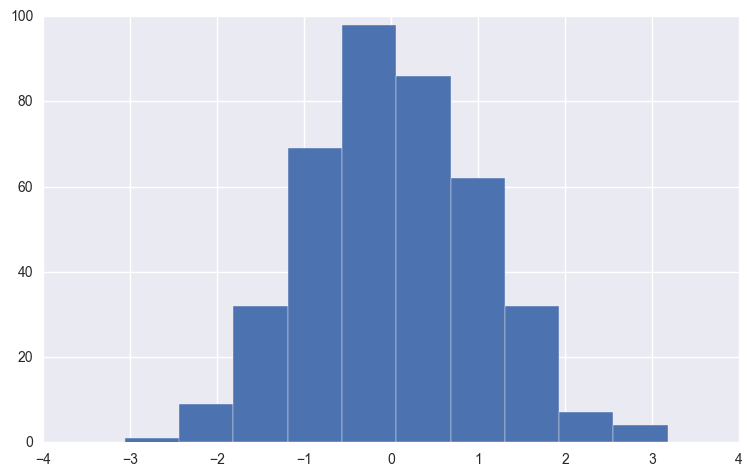

In [115]:
# just see what dist1 is
plt.hist(dist1);

In [116]:
# To make a "good" movie set with scores around 7.
# Idea is that these are all good movies (7s) and the distribution comes from the model's error
good_movies = scale_movie_set(dist1, 7, 0.5)

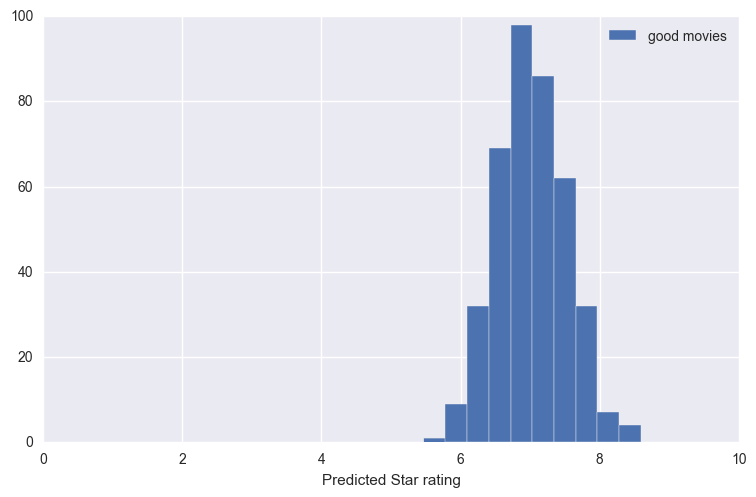

In [117]:
plt.hist(good_movies,label='good movies');
plt.xlim(0,10)
plt.xlabel('Predicted Star rating');
plt.legend(loc='upper right')


Let's make some bad movies and add them. All bad movies will be rated at 5, but there is some error in their spread

In [118]:
bad_movies = scale_movie_set(dist2, 5,0.9)

In [123]:
def get_targets_and_scores():
    # list good movies, then bad
    targets = [1]*len(good_movies) + [0]*len(bad_movies)
    # have to put scores in the same order (good then bad) to match
    prediction_scores = np.concatenate((good_movies, bad_movies))
    
    return targets, prediction_scores

def print_precision_and_recall(threshold):
    targets, prediction_scores = get_targets_and_scores()
    
    hard_predictions = (prediction_scores > threshold)
    print("Precision: ", precision_score(targets, hard_predictions))
    print("Recall: ", recall_score(targets, hard_predictions))
    
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def make_movie_plot(threshold=7.0):
    plt.figure(figsize=(15,14))
    plt.subplot(2, 1, 1)
    plt.hist(good_movies, alpha=0.7, label='actually good')
    plt.hist(bad_movies, alpha=0.7, label='actually bad')
    plt.xlim(0,10)
    plt.xlabel('Predicted star rating')
    plt.legend(loc='upper left')
    plt.axvline(threshold,c='k', ls='--', lw=1)
    
    plt.subplot(2, 1, 2)
    targets, star_score = get_targets_and_scores()
    fpr, tpr, threshold_array = roc_curve(targets, star_score)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    idx = np.abs(threshold_array - threshold).argmin()
    
    plt.plot([fpr[idx]], [tpr[idx]], 'ro', ms=15)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    # put in good movies, then bad movies
    print_precision_and_recall(threshold)

Precision:  0.5
Recall:  1.0


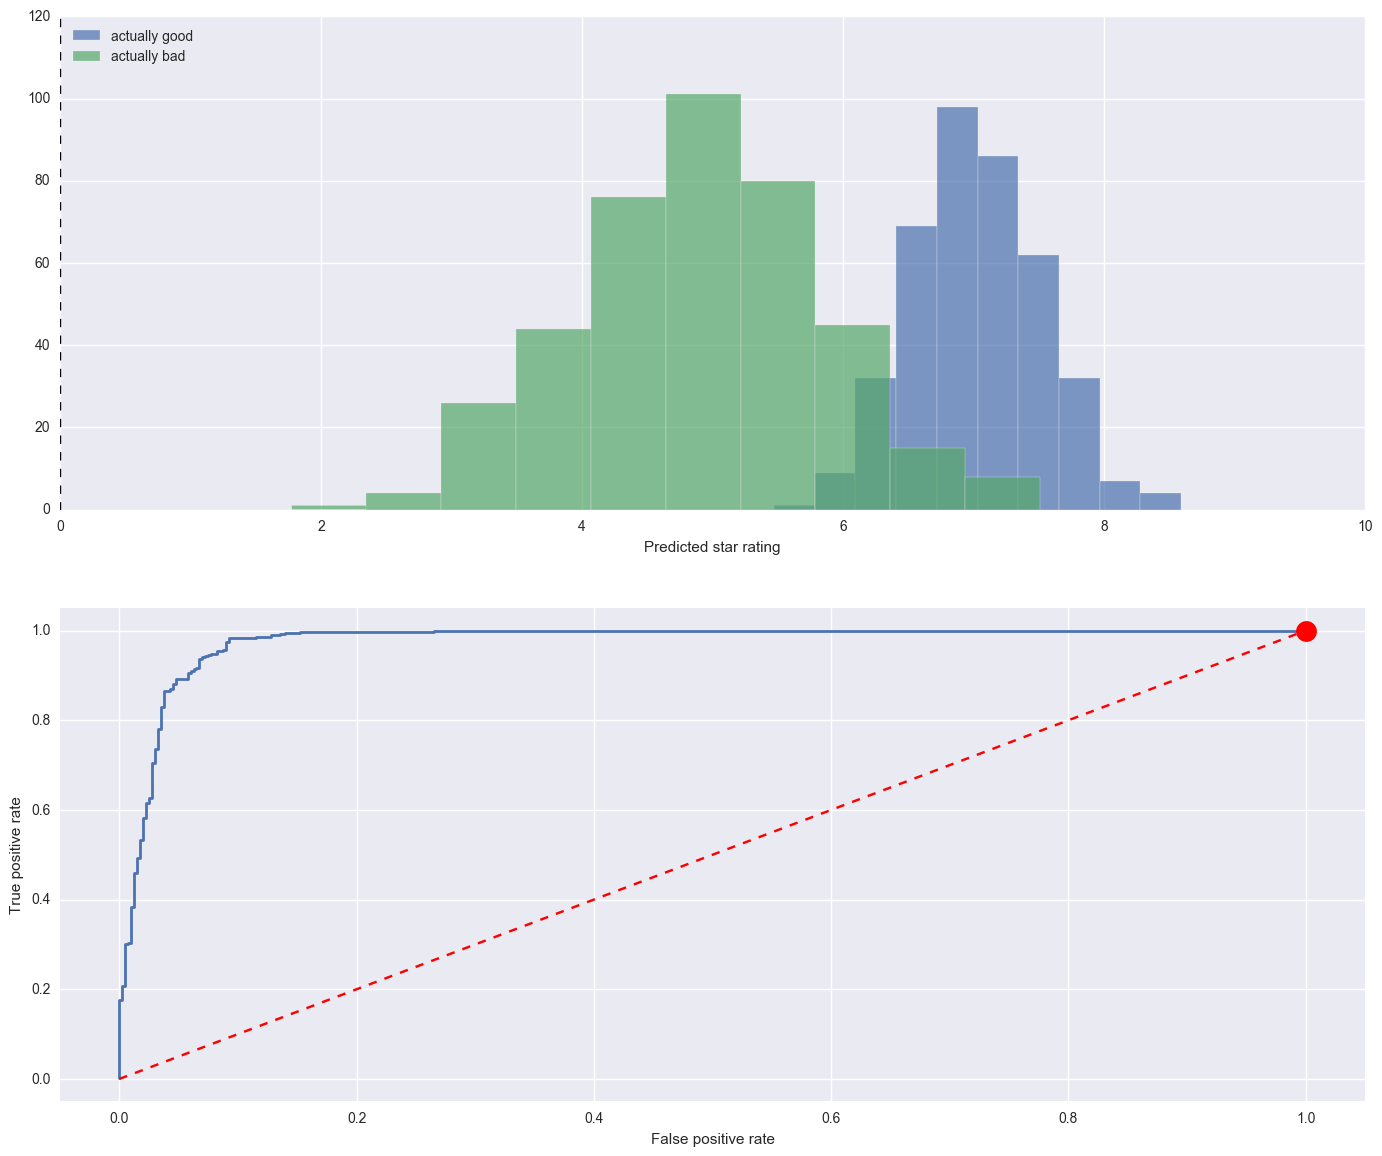

In [124]:
threshold_slider = FloatSlider(min=0, max=10, step=0.05, continuous_update=False)
interactive(make_movie_plot, threshold=threshold_slider)